<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/tasks/source-separation.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/tasks/source-separation.ipynb)

# Source Separation

## Introduction

In source separation, the goal is to be able to separate out the sources from an observed mixture signal which consists of superposition of several sources. Let us demonstrate this with an example.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = 1000
t = np.arange(0, T)
fs = 3000
f0 = 10

source1 = np.sin(2*np.pi*(f0/fs)*t) + 0.1*np.random.randn(T)
source2 = np.sin(2*np.pi*(3*f0/fs)*t)+ 0.1*np.random.randn(T)
mixture = source1 + source2

plt.subplot(311)
plt.plot(source1)
plt.title('Source 1')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(312)
plt.plot(source2)
plt.title('Source 2')
plt.xticks(np.arange(0, 100, T), '')

plt.subplot(313)
plt.plot(mixture)
plt.title('Mixture')
plt.show()

The goal is to get Source 1 and Source 2 from the Mixture Signal. In our case Source 1 is a noisy sinosoid with frequency f0, and Source is a noisy sinusoid with frequency 3*f0.  

## A toy example

Now, let's consider a slightly more interesting case where, source 1 is a sinusoid with a random frequency smaller than f_threshold, and source 2 is a sinusoid with frequency larger than f_threshold. Let's first build the dataset and and the dataloaders using speechbrain. We will then build a model which will able to separate out the sources successfully.

In [ ]:
import torch
import torch.utils.data as data_utils
import librosa.display as lrd

N = 100
f_th = 200
fs = 8000

T = 10000
t = torch.arange(0, T).unsqueeze(0)
f1 = torch.randint(5, f_th, (N, 1))
f2 = torch.randint(f_th, 400, (N, 1))
batch_size = 10

source1 = torch.sin(2*np.pi*(f1/fs)*t)
source2 = torch.sin(2*np.pi*(f2/fs)*t)
mixture = source1 + source2
N_train = 90
train_dataset = data_utils.TensorDataset(source1[:N_train], source2[:N_train], mixture[:N_train])
test_dataset = data_utils.TensorDataset(source1[N_train:], source2[N_train:], mixture[N_train:])

train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size)

# now let's visualize the frequency spectra for the dataset
fft_size = 200

plt.figure(figsize=[20, 10], dpi=50)

plt.subplot(131)
mix_gt = mixture[N_train]
mix_spec = torch.sqrt((torch.view_as_real(torch.stft(mix_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(mix_spec.numpy(), y_axis='log')
plt.title('Mixture Spectrogram')

plt.subplot(132)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Source 1 Spectrogram')

plt.subplot(133)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Source 2 Spectrogram')

plt.show()


Now that we created the dataset, we can now focus on building a model would be able to recover the original sources from the mixture signal. For this, we will use speechbrain. Let us first install speechbrain.

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

Now, let us construct a simple model with pytorch and speechbrain for source separation.

In [ ]:
import speechbrain as sb
import torch.nn as nn

# define the model
class simpleseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2):
    super(simpleseparator, self).__init__()
    self.masking = nn.LSTM(input_size=fft_size//2 + 1, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size//2 + 1))
    self.fft_size=fft_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x freq x time x realim
    y = torch.view_as_real(torch.stft(inp, n_fft=self.fft_size, return_complex=True))

    # batch X freq x time
    mag = torch.sqrt((y ** 2).sum(-1))
    phase = torch.atan2(y[:, :, :, 1], y[:, :, :, 0])

    # batch x time x freq
    mag = mag.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.masking(mag)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)

    # batch x time x nfft x num_sources
    lin_out = nn.functional.relu(lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources))

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = (lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude
      sourcehat_dft = (sourcehat_mask * mag).permute(0, 2, 1) * torch.exp(1j * phase)

      # reconstruct in time domain with istft
      sourcehat = torch.istft(sourcehat_dft, n_fft=self.fft_size)
      sources.append(sourcehat)
    return sources, all_masks, mag

# test_forwardpass
model = simpleseparator(fft_size=fft_size, hidden_size=300)
est_sources, _, _ = model.forward(mixture[:5])

Now that our model, we can now write the Brain class for training.


In [ ]:
class SeparationBrain(sb.Brain):
    def __init__(self, train_loss, modules, opt_class):
        super(SeparationBrain, self).__init__(modules=modules, opt_class=opt_class)
        self.train_loss = train_loss

    def compute_forward(self, mix):
        """Forward computations from the mixture to the separated signals."""

        # Get the estimates for the sources
        est_sources, _, _ = self.modules.mdl(mix)

        est_sources = torch.stack(est_sources, dim=-1)

        # T changed after conv1d in encoder, fix it here
        T_origin = mix.size(1)
        T_est = est_sources.size(1)
        if T_origin > T_est:
            est_sources = nn.functional.pad(est_sources, (0, 0, 0, T_origin - T_est))
        else:
            est_sources = est_sources[:, :T_origin, :]

        return est_sources

    def compute_objectives(self, targets, est_sources):
        """Computes the loss functions between estimated and ground truth sources"""
        if self.train_loss == 'l1':
          return (est_sources - targets).abs().mean()
        elif self.train_loss == 'si-snr':
          return sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources).mean()


    def fit_batch(self, batch):
        """Trains one batch"""
        # Unpacking batch list
        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)
        loss = self.compute_objectives(targets, est_sources)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for test batches"""

        source1, source2, mix = batch
        targets = torch.stack([source1, source2], dim=-1)

        est_sources = self.compute_forward(mix)

        si_snr = sb.nnet.losses.get_si_snr_with_pitwrapper(targets, est_sources)
        si_snr_mean = si_snr.mean().item()
        print('VALID SI-SNR = {}'.format(-si_snr_mean))
        return si_snr.mean().detach()


from functools import partial

optimizer = lambda x: torch.optim.Adam(x, lr=0.0001)
N_epochs = 10
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='l1',
        modules={'mdl': model},
        opt_class=optimizer

    )


separator.fit(
            epoch_counter,
            train_loader,
            test_loader)


Now, let's visualize the results. For this purpose let's first install librosa. It has a nice tool for visualizing spectrograms.  




In [ ]:
%%capture
!pip install librosa


We will first plot the the spectra for the ground truth sources. And then we will run a forward pass with the model and plot the estimated sources.

In [ ]:
estimated_sources, all_masks, mag = separator.modules.mdl.forward(mixture[N_train:])


plt.figure(figsize=[20, 10], dpi=80)

plt.subplot(331)
mag = mag[0].t().numpy()
lrd.specshow(mag, y_axis='log')
plt.title('Mixture')

plt.subplot(334)
mask1 = all_masks[0][0].detach().t().numpy()
lrd.specshow(mask1, y_axis='log')
plt.title('Mask for source 1')

plt.subplot(335)
masked1 = mask1 * mag
lrd.specshow(masked1, y_axis='log')
plt.title('Estimated Source 1')

plt.subplot(336)
source1_gt = source1[N_train]
source1_spec = torch.sqrt((torch.view_as_real(torch.stft(source1_gt, n_fft=fft_size, return_complex=True))**2).sum(-1))
lrd.specshow(source1_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 1')

plt.subplot(337)
mask2 = all_masks[1][0].detach().t().numpy()
lrd.specshow(mask2, y_axis='log')
plt.title('Mask for Source 2')

plt.subplot(338)
masked2 = mask2 * mag
lrd.specshow(masked2, y_axis='log')
plt.title('Estimated Source 2')

plt.subplot(339)
source2_gt = source2[N_train]
source2_spec = torch.sqrt((torch.view_as_real(torch.stft(source2_gt, n_fft=fft_size, return_complex=True)**2)).sum(-1))
lrd.specshow(source2_spec.numpy(), y_axis='log')
plt.title('Ground Truth Source 2')

plt.show()


Notice that these masks are basically band stop filters which aims to remove the interferences from the other source.

## Exercises

* Train the same model with SI-SNR loss and observe if this helps to improve the performance.
* Replace the STFT front end, and the ISTFT reconstruction with convolutional layer, and transposed convolution layers. Do the same visualization above, also visualize the filters learnt by the convolutional front end, and the reconstruction layer, and compare it with the DFT bases.  


## A sound source separation example with a pre-existing model from speechbrain

First, let's download the dataset.

In [ ]:
%%capture
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AADx5I8oV0IdekCf80MSkxMia/mixture_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAZI7ZezKyHFGPdus6hn2v_a/mixture_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACh4Yy4H-Ii2I0mr_b1lQdXa/mixture_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAAenTlEsoj1-AGbCxeJfMHoa/mixture_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC-awQo-9NFVVULuVwaHKKWa/source1_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABVKWtdVhXZE6Voq1I_c6g5a/source1_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC9EfjTTwL0dscH16waP9s-a/source1_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AAC5Ozb4rS9qby268JSIy5Uwa/source1_3.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AABlonG910Ms2l-rTN5ct3Oka/source2_0.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACDOqEgyXIeA2r1Rkf7VgQTa/source2_1.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACTYGAG0LOh6HvxpVYoqO_Da/source2_2.wav
!wget https://www.dropbox.com/sh/07vwpwru6qo6yhf/AACPmq-ZJNzfh4bnO34_8mfAa/source2_3.wav

Now let's first listen to these sounds.

In [ ]:
import speechbrain
from speechbrain.dataio.dataio import read_audio
from IPython.display import Audio

mixture_0 = read_audio('mixture_0.wav').squeeze()
source1_0 = read_audio('source1_0.wav').squeeze()
source2_0 = read_audio('source2_0.wav').squeeze()

mixture_1 = read_audio('mixture_1.wav').squeeze()
source1_1 = read_audio('source1_1.wav').squeeze()
source2_1 = read_audio('source2_1.wav').squeeze()

mixture_2 = read_audio('mixture_2.wav').squeeze()
source1_2 = read_audio('source1_2.wav').squeeze()
source2_2 = read_audio('source2_2.wav').squeeze()

mixture_3 = read_audio('mixture_3.wav').squeeze()
source1_3 = read_audio('source1_3.wav').squeeze()
source2_3 = read_audio('source2_3.wav').squeeze()

train_mixs = [mixture_0, mixture_1, mixture_2]
train_source1s = [source1_0, source1_1, source1_2]
train_source2s = [source2_0, source2_1, source2_2]

Audio(mixture_0, rate=16000)

In [ ]:
Audio(source1_0, rate=16000)

In [ ]:
Audio(source2_0, rate=16000)


Now, let's construct the datasets and dataloaders.

In [ ]:
from torch.utils.data import Dataset, DataLoader


class source_separation_dataset(Dataset):
    def __init__(self, train_mixs, train_source1s, train_source2s):
        self.mixs = train_mixs
        self.train_source1s = train_source1s
        self.train_source2s = train_source2s

    def __len__(self):
        return len(self.mixs)

    def __getitem__(self, idx):
        mix = self.mixs[idx]
        source1 = self.train_source1s[idx]
        source2 = self.train_source2s[idx]
        return mix, source1, source2

train_dataset_audio = source_separation_dataset(train_mixs, train_source1s, train_source2s)
valid_dataset_audio = source_separation_dataset([mixture_2], [source1_2], [source2_2])

train_loader_audio = DataLoader(train_dataset_audio, batch_size=1)
valid_loader_audio = DataLoader(valid_dataset_audio, batch_size=1)


And now, let's tinker the model we constructed and use it on this small dataset. For this purpose we will use the mask-based end-to-end architecture:

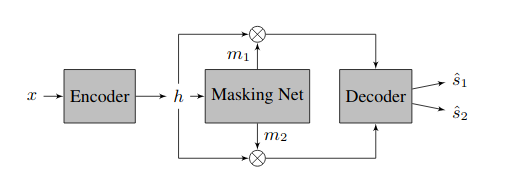




In [ ]:
fft_size=1024
model_audio = simpleseparator(fft_size=fft_size, hidden_size=300)


optimizer = lambda x: torch.optim.Adam(x, lr=0.0005)
N_epochs = 100
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer

    )


separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)



In [ ]:
class audioseparator(nn.Module):
  def __init__(self, fft_size, hidden_size, num_sources=2, kernel_size=16):
    super(audioseparator, self).__init__()
    self.encoder = nn.Conv1d(in_channels=1, out_channels=fft_size, kernel_size=16, stride=kernel_size//2)

    # MaskNet
    self.rnn = nn.LSTM(input_size=fft_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
    self.output_layer = nn.Linear(in_features=hidden_size*2, out_features=num_sources*(fft_size))

    self.decoder = nn.ConvTranspose1d(in_channels=fft_size, out_channels=1, kernel_size=kernel_size, stride=kernel_size//2)

    self.fft_size = fft_size
    self.hidden_size = hidden_size
    self.num_sources = num_sources

  def forward(self, inp):
    # batch x channels x time
    y = nn.functional.relu(self.encoder(inp.unsqueeze(0)))

    # batch x time x nfft
    y = y.permute(0, 2, 1)

    # batch x time x feature
    rnn_out = self.rnn(y)[0]

    # batch x time x (nfft*num_sources)
    lin_out = self.output_layer(rnn_out)

    # batch x time x nfft x num_sources
    lin_out = lin_out.reshape(lin_out.size(0), lin_out.size(1), -1, self.num_sources)

    # reconstruct in time domain
    sources = []
    all_masks = []
    for n in range(self.num_sources):
      sourcehat_mask = nn.functional.relu(lin_out[:, :, :, n])
      all_masks.append(sourcehat_mask)

      # multiply with mask and magnitude
      T = sourcehat_mask.size(1)
      sourcehat_latent = (sourcehat_mask * y[:, :T, :]).permute(0, 2, 1)

      # reconstruct in time domain with istft
      sourcehat = self.decoder(sourcehat_latent).squeeze(0)
      sources.append(sourcehat)

    return sources, all_masks, y

model_audio = audioseparator(fft_size=fft_size, hidden_size=300, kernel_size=256)
out, _, _ = model_audio.forward(mixture_0.unsqueeze(0))


In [ ]:
optimizer = lambda x: torch.optim.Adam(x, lr=0.0002)
N_epochs = 200
epoch_counter = sb.utils.epoch_loop.EpochCounter(limit=N_epochs)

separator = SeparationBrain(
        train_loss='si-snr',
        modules={'mdl': model_audio},
        opt_class=optimizer

    )

separator.fit(
            epoch_counter,
            train_loader_audio,
            valid_loader_audio)


In [ ]:
estimated_sources_test, all_masks, mag = model_audio.forward(mixture_3.unsqueeze(0))
estimated_sources_train, all_masks, mag = model_audio.forward(mixture_0.unsqueeze(0))


Audio(estimated_sources_test[0].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_test[1].squeeze().detach(), rate=16000)


In [ ]:
Audio(estimated_sources_train[0].squeeze().detach(), rate=16000)

In [ ]:
Audio(estimated_sources_train[1].squeeze().detach(), rate=16000)

It does not work that great because of the introduced artifacts, but we can hear that it supresses the interferences.

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```